# Librerias y Lectura Archivos

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input

In [2]:
#importacion df_final
df=pd.read_csv('../data/processed/final_merge.csv')

In [3]:
df

,edad,sexo,nivel_educativo,fumador,actividad_fisica,vive,diabetes,hipertension,obesidad,cancer,...,region_Sur,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,continente_America,continente_Antarctica,continente_Asia,continente_Europe,continente_Oceania
0,69,0,1,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,1,0,0
1,32,1,2,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
2,89,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,78,1,1,1,0,0,1,0,1,1,...,0,0,0,0,1,0,0,1,0,0
4,38,0,3,1,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47605,21,1,2,0,2,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
47606,35,0,3,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
47607,46,1,1,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
47608,56,1,3,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [4]:
df.shape

(47610, 48)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47610 entries, 0 to 47609
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   edad                     47610 non-null  int64  
 1   sexo                     47610 non-null  int64  
 2   nivel_educativo          47610 non-null  int64  
 3   fumador                  47610 non-null  int64  
 4   actividad_fisica         47610 non-null  int64  
 5   vive                     47610 non-null  int64  
 6   diabetes                 47610 non-null  int64  
 7   hipertension             47610 non-null  int64  
 8   obesidad                 47610 non-null  int64  
 9   cancer                   47610 non-null  int64  
 10  enfermedad_cardiaca      47610 non-null  int64  
 11  epoc                     47610 non-null  int64  
 12  glucosa                  47610 non-null  float64
 13  colesterol               47610 non-null  float64
 14  trigliceridos         

# Estandarización Variables

In [6]:
numerical_columns = ['edad', 'glucosa', 'colesterol', 'trigliceridos', 
                     'hemoglobina', 'leucocitos', 'plaquetas', 'creatinina', 
                     'ingresos_mensuales', 'gastos_salud']

In [7]:
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df[numerical_columns].head()

,edad,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,ingresos_mensuales,gastos_salud
0,0.752464,1.182348,1.148022,0.538101,-0.269240,-0.948031,0.209374,-0.325816,1.525607,2.521666
1,-1.028350,-1.578028,-1.785944,-1.386118,0.182589,-0.084302,0.732393,-0.904565,2.597109,-0.876769
2,1.715066,-0.430133,-0.698475,-2.106839,-0.762145,0.494905,-0.120001,2.664386,1.103434,-0.876769
3,1.185635,-0.245735,0.305460,-0.964549,-0.567037,1.531380,-0.126206,1.072827,-0.003326,2.521666
4,-0.739569,-1.981947,-1.579386,-2.626722,-1.193437,1.165565,-0.402064,-0.759878,0.018125,-0.876769


## Red Neuronal

In [8]:
 X = df.drop(columns=['vive'])
 y = df['vive']

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelo Simple

In [10]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),# desactivar neuronas evitar sobreajuste
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Salida binaria
])


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [12]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/30


953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.8583 - loss: 0.3851 - precision: 0.8708 - recall: 0.9828 - val_accuracy: 0.8728 - val_loss: 0.3270 - val_precision: 0.8728 - val_recall: 0.9998
Epoch 2/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.8713 - loss: 0.3347 - precision: 0.8736 - recall: 0.9962 - val_accuracy: 0.8728 - val_loss: 0.3242 - val_precision: 0.8753 - val_recall: 0.9961
Epoch 3/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.8717 - loss: 0.3283 - precision: 0.8743 - recall: 0.9957 - val_accuracy: 0.8735 - val_loss: 0.3239 - val_precision: 0.8769 - val_recall: 0.9946
Epoch 4/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.8775 - loss: 0.3211 - precision: 0.8814 - recall: 0.9936 - val_accuracy: 0.8721 - val_loss: 0.3241 - val_precision: 0.8747 - val_recall: 0.9961
Epoch 5/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.8724 - loss: 0.3243 - precision: 0.8764 - recall: 0.9937 - val_accuracy: 0.8720 - val_loss: 0.3

In [13]:
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


In [14]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Confusion Matrix:
 [[  73 1128]
 [  97 8224]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.06      0.11      1201
           1       0.88      0.99      0.93      8321

    accuracy                           0.87      9522
   macro avg       0.65      0.52      0.52      9522
weighted avg       0.82      0.87      0.83      9522

F1 Score: 0.9306852260510383


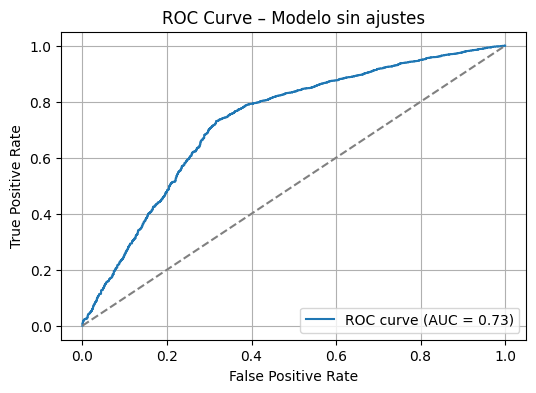

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Modelo sin ajustes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Modelo Simple**
- Acierta mucho prediciendo que la gente sobrevive (porque es la mayoría).
- Pero ignora completamente a la clase 0 (los que no sobreviven).
- Muchísimos falsos positivos, que es lo que tú quieres evitar.

## Class Weight

Nuestro dataset está desbalanceado: la mayoría de los pacientes sobreviven (`vive = 1`) y una minoría no (`vive = 0`).  
Esto provoca que el modelo base tienda a **ignorar la clase 0**, cometiendo muchos **falsos positivos** (predice que sobrevivirán y no lo hacen).

**Class Weight**

Class_weight es una técnica que permite **dar más importancia a los errores cometidos en la clase minoritaria**, multiplicando su impacto durante el entrenamiento.

La fórmula usada para calcular los pesos automáticamente es:

$
w_c = \frac{n}{k \cdot n_c}
$

Donde:

-$ w_c $ peso asignado a la clase \( c \)  
- $ n $: total de muestras  
- $k $: número de clases  
- $ n_c$: cantidad de muestras en la clase \( c \)




**Pesos asignados a cada clase**

In [16]:
weights = compute_class_weight(
    class_weight='balanced',    # que lo calcule en base al desbalanceo
    classes=np.unique(y),       # las clases que hay (0 y 1)
    y=y                         # tu variable objetivo
)

# Paso 2: Crear el diccionario para Keras
class_weight = {0: weights[0], 1: weights[1]}

# Mostrar los pesos
print("Pesos calculados automáticamente:", class_weight)

Pesos calculados automáticamente: {0: np.float64(3.919808990614194), 1: np.float64(0.5731034980860438)}


In [17]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [19]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/30


953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - accuracy: 0.6310 - loss: 0.6458 - precision_1: 0.9220 - recall_1: 0.6271 - val_accuracy: 0.7636 - val_loss: 0.5419 - val_precision_1: 0.9462 - val_recall_1: 0.7729
Epoch 2/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.7491 - loss: 0.5851 - precision_1: 0.9436 - recall_1: 0.7575 - val_accuracy: 0.7573 - val_loss: 0.5728 - val_precision_1: 0.9484 - val_recall_1: 0.7632
Epoch 3/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.7532 - loss: 0.5752 - precision_1: 0.9453 - recall_1: 0.7614 - val_accuracy: 0.7608 - val_loss: 0.5332 - val_precision_1: 0.9470 - val_recall_1: 0.7688
Epoch 4/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.7575 - loss: 0.5794 - precision_1: 0.9444 - recall_1: 0.7663 - val_accuracy: 0.7564 - val_loss: 0.5745 - val_precision_1: 0.9490 - val_recall_1: 0.7616
Epoch 5/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.7612 - loss: 0.5609 - precision_1: 0.9490 - recall_1: 0.7680 - 

In [20]:
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


In [21]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Confusion Matrix:
 [[ 827  374]
 [2303 6018]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.69      0.38      1201
           1       0.94      0.72      0.82      8321

    accuracy                           0.72      9522
   macro avg       0.60      0.71      0.60      9522
weighted avg       0.86      0.72      0.76      9522

F1 Score: 0.818052062801604


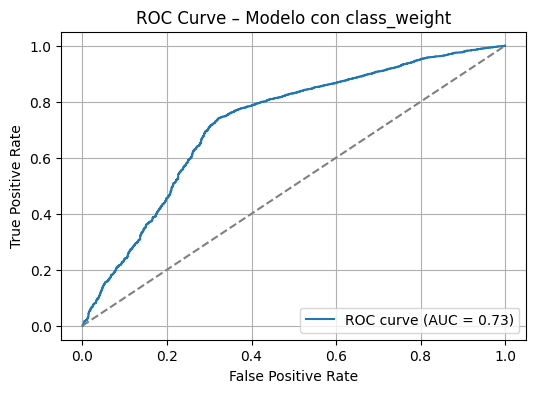

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Modelo con class_weight')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Probamso con diferentes umbrales de precisión

In [23]:
y_probs = model.predict(X_test).ravel()

# Umbrales a probar
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds:
    print(f"\n🔎 UMBRAL: {t}")
    y_pred_thresh = (y_probs > t).astype(int)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_thresh)
    print("Confusion Matrix:\n", cm)
    
    # Reporte de métricas
    report = classification_report(y_test, y_pred_thresh, digits=3)
    print("Classification Report:\n", report)
    
    # F1 global
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"F1 Score: {f1:.4f}")

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step

🔎 UMBRAL: 0.3
Confusion Matrix:
 [[ 486  715]
 [1119 7202]]
Classification Report:
               precision    recall  f1-score   support

           0      0.303     0.405     0.346      1201
           1      0.910     0.866     0.887      8321

    accuracy                          0.807      9522
   macro avg      0.606     0.635     0.617      9522
weighted avg      0.833     0.807     0.819      9522

F1 Score: 0.8871

🔎 UMBRAL: 0.4
Confusion Matrix:
 [[ 753  448]
 [1876 6445]]
Classification Report:
               precision    recall  f1-score   support

           0      0.286     0.627     0.393      1201
           1      0.935     0.775     0.847      8321

    accuracy                          0.756      9522
   macro avg      0.611     0.701     0.620      9522
weighted avg      0.853     0.756     0.790      9522

F1 Score: 0.8472

🔎 UMBRAL: 0.5
Confusion Matrix:
 [[ 827  374]
 [2303 6018]]
Classification Report:
               

##mejor



🔎 UMBRAL: 0.6
Confusion Matrix:
 [[ 875  326]
 [3000 5321]]
Classification Report:
               precision    recall  f1-score   support

           0      0.226     0.729     0.345      1201
           1      0.942     0.639     0.762      8321

    accuracy                          0.651      9522
   macro avg      0.584     0.684     0.553      9522
weighted avg      0.852     0.651     0.709      9522

F1 Score: 0.7619



## Modelo Oversample

Añade nuevos ejemplos sintéticos de la clase minoritaria (vive = 0)

In [24]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [25]:
print("Antes del SMOTE:", np.bincount(y_train))
print("Después del SMOTE:", np.bincount(y_train_smote))

Antes del SMOTE: [ 4872 33216]
Después del SMOTE: [33216 33216]


In [26]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [28]:
history = model.fit(X_train_smote, y_train_smote,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 2s 591us/step - accuracy: 0.7623 - loss: 0.4918 - precision_2: 0.7641 - recall_2: 0.9039 - val_accuracy: 0.8620 - val_loss: 0.3169 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - accuracy: 0.8365 - loss: 0.3845 - precision_2: 0.8385 - recall_2: 0.9131 - val_accuracy: 0.8681 - val_loss: 0.2836 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8508 - loss: 0.3549 - precision_2: 0.8471 - recall_2: 0.9293 - val_accuracy: 0.8894 - val_loss: 0.2423 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.8542 - loss: 0.3458 - precision_2: 0.8473 - recall_2: 0.9360 - val_accuracy: 0.8937 - val_loss: 0.2298 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.8608 - los

In [29]:
# 7. Evaluar en test con umbral 0.5
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"\nF1 Score: {f1_score(y_test, y_pred):.4f}")

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step

Confusion Matrix:
[[ 169 1032]
 [ 478 7843]]

Classification Report:
              precision    recall  f1-score   support

           0      0.261     0.141     0.183      1201
           1      0.884     0.943     0.912      8321

    accuracy                          0.841      9522
   macro avg      0.572     0.542     0.548      9522
weighted avg      0.805     0.841     0.820      9522


F1 Score: 0.9122


In [30]:
# 7. Evaluar en test con umbral 0.6
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.6).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"\nF1 Score: {f1_score(y_test, y_pred):.4f}")

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step

Confusion Matrix:
[[ 337  864]
 [ 862 7459]]

Classification Report:
              precision    recall  f1-score   support

           0      0.281     0.281     0.281      1201
           1      0.896     0.896     0.896      8321

    accuracy                          0.819      9522
   macro avg      0.589     0.589     0.589      9522
weighted avg      0.819     0.819     0.819      9522


F1 Score: 0.8963


## SMOTE + Pesos

In [31]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print("Después de SMOTE:", np.bincount(y_train_smote))

# 3. Calcular class_weight AUTOMÁTICAMENTE sobre los datos balanceados
class_weight = {0: 2.0, 1: 1.0}
print("Pesos manuales aplicados:", class_weight)

# 4. Definir el modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 5. Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# 6. Entrenar el modelo con class_weight
history = model.fit(X_train_smote, y_train_smote,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight,
                    verbose=1)

# 7. Evaluar en test con umbral 0.5
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"\nF1 Score: {f1_score(y_test, y_pred):.4f}")

Después de SMOTE: [33216 33216]
Pesos manuales aplicados: {0: 2.0, 1: 1.0}
Epoch 1/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.7313 - loss: 0.7235 - precision_3: 0.8228 - recall_3: 0.7242 - val_accuracy: 0.9281 - val_loss: 0.1831 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.8228 - loss: 0.5552 - precision_3: 0.8761 - recall_3: 0.8350 - val_accuracy: 0.9332 - val_loss: 0.1594 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.8330 - loss: 0.5211 - precision_3: 0.8844 - recall_3: 0.8421 - val_accuracy: 0.9331 - val_loss: 0.1647 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/30
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - accuracy: 0.8376 - loss: 0.5063 - precision_3: 0.8859 - recall_3: 0.8496 - val_accuracy: 0.9454 - val_loss: 0.1369 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch

## UnderSample

In [33]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [34]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("Distribución después de undersampling:", Counter(y_rus))

# 2. Definir el modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 3. Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# 4. Entrenar con los datos reducidos (sin class_weight)
history = model.fit(X_rus, y_rus,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    verbose=1)

# 5. Evaluar en test
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"\nF1 Score: {f1_score(y_test, y_pred):.4f}")

Distribución después de undersampling: Counter({0: 4872, 1: 4872})
Epoch 1/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6443 - loss: 0.6331 - precision_4: 0.5603 - recall_4: 0.3187 - val_accuracy: 0.4746 - val_loss: 0.8849 - val_precision_4: 1.0000 - val_recall_4: 0.4746
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.6985 - loss: 0.5767 - precision_4: 0.6135 - recall_4: 0.5042 - val_accuracy: 0.6337 - val_loss: 0.8139 - val_precision_4: 1.0000 - val_recall_4: 0.6337
Epoch 3/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.6976 - loss: 0.5818 - precision_4: 0.6111 - recall_4: 0.5556 - val_accuracy: 0.7070 - val_loss: 0.7685 - val_precision_4: 1.0000 - val_recall_4: 0.7070
Epoch 4/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7152 - loss: 0.5589 - precision_4: 0.6224 - recall_4: 0.6273 - val_accuracy: 0.6685 - val_loss: 0.8063 - val_precision_4: 1.0000 - val_recall_4: 0.6685
Epoch 5/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step -

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# 1. Predecir probabilidades
y_probs = model.predict(X_test).ravel()

# 2. Probar distintos umbrales
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred = (y_probs > threshold).astype(int)
    print(f"\n🔎 UMBRAL: {threshold}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step

🔎 UMBRAL: 0.3
Confusion Matrix:
[[ 768  433]
 [2055 6266]]

Classification Report:
              precision    recall  f1-score   support

           0      0.272     0.639     0.382      1201
           1      0.935     0.753     0.834      8321

    accuracy                          0.739      9522
   macro avg      0.604     0.696     0.608      9522
weighted avg      0.852     0.739     0.777      9522

F1 Score: 0.8344

🔎 UMBRAL: 0.4
Confusion Matrix:
[[ 845  356]
 [2663 5658]]

Classification Report:
              precision    recall  f1-score   support

           0      0.241     0.704     0.359      1201
           1      0.941     0.680     0.789      8321

    accuracy                          0.683      9522
   macro avg      0.591     0.692     0.574      9522
weighted avg      0.853     0.683     0.735      9522

F1 Score: 0.7894

🔎 UMBRAL: 0.5
Confusion Matrix:
[[ 925  276]
 [3712 4609]]

Classification Report:
              pre

## focal loss

In [36]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [37]:
def focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())  # evitar log(0)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(K.equal(y_true, 1), 1 - alpha, alpha)
        focal_weight = alpha_factor * K.pow(1. - pt, gamma)
        return -K.mean(focal_weight * K.log(pt))
    return loss

In [38]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [39]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=focal_loss(alpha=0.75, gamma=2.0),
              metrics=['accuracy', Precision(), Recall()])

Epoch 1/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.7654 - loss: 0.0512 - precision_5: 0.8902 - recall_5: 0.8341 - val_accuracy: 0.8473 - val_loss: 0.0422 - val_precision_5: 0.8994 - val_recall_5: 0.9288
Epoch 2/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.8259 - loss: 0.0423 - precision_5: 0.9108 - recall_5: 0.8882 - val_accuracy: 0.8249 - val_loss: 0.0414 - val_precision_5: 0.9150 - val_recall_5: 0.8811
Epoch 3/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.8184 - loss: 0.0418 - precision_5: 0.9160 - recall_5: 0.8717 - val_accuracy: 0.8307 - val_loss: 0.0412 - val_precision_5: 0.9136 - val_recall_5: 0.8900
Epoch 4/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.8156 - loss: 0.0412 - precision_5: 0.9226 - recall_5: 0.8603 - val_accuracy: 0.8102 - val_loss: 0.0409 - val_precision_5: 0.9261 - val_recall_5: 0.8502
Epoch 5/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.8142 - loss: 0.0409 - precision_5: 0.9261 - recall_5

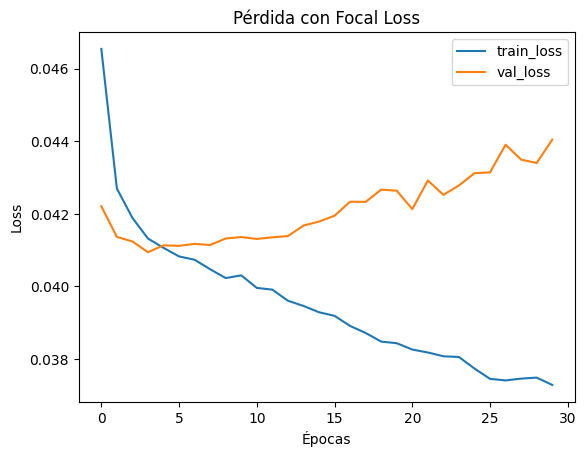

In [40]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# 5. Predecir y evaluar (umbral 0.5)
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"\nF1 Score: {f1_score(y_test, y_pred):.4f}")

# 6. Plot pérdida
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Pérdida con Focal Loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

## keras tunners

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from keras_tuner import Hyperband
from sklearn.utils.class_weight import compute_class_weight

In [43]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weight)

# 2. Definir modelo como función para el tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )
    return model

# 3. Definir tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuner_dir',
    project_name='binary_classification_tuning'
)

# 4. Callback para detener si no mejora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# 5. Lanzar búsqueda
tuner.search(X_train, y_train,
             epochs=20,
             validation_split=0.2,
             class_weight=class_weight,
             callbacks=[stop_early],
             verbose=1)

# 6. Obtener mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Mejores hiperparámetros:", best_hps.values)

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.7625361084938049

Best val_accuracy So Far: 0.7642425894737244
Total elapsed time: 00h 02m 05s
Mejores hiperparámetros: {'units1': 96, 'dropout1': 0.4, 'units2': 32, 'lr': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [54]:
pip install -U keras-tuner

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
